# Data modelling

Models to try:
- [ ] Linear Regression
- [x] Linear Regression with regularisation (L1 - ridge)
- [x] Linear Regression with regularisation (L2 - lasso)
- [ ] Linear Regression with regularisation (elanstic net)
- [ ] [Extra Trees](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)
- [x] [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- [ ] [Gradient Boosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)
- [ ] neural network
- [ ] LightGbm
- [x] xgboost

In [41]:
from sklearn.model_selection import cross_val_score
import numpy as np
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 7))
    return(rmse)

In [46]:
?pd.get_dummies

## Load pre-processed data from pickles

In [12]:
!ls data

data_description.txt  test.csv              train.csv
sample_submission.csv test.pkl              train.pkl


In [13]:
import pandas as pd

In [14]:
train = pd.read_pickle("./data/train.pkl")
test = pd.read_pickle("./data/test.pkl")

## Create matrixes

In [15]:
# remove Id and target variable
X_train = train[train.columns.values[1:-1]]
y_train = train[train.columns.values[-1]]

# remove Id
X_test = test[test.columns.values[1:]]

## RandomForest (LB: 0.14591)

/Users/robert/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


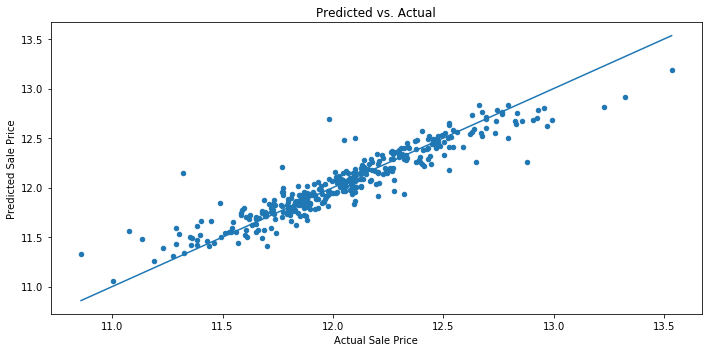

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)
model_rf = RandomForestRegressor(n_estimators=500, n_jobs=-1)

model_rf.fit(X_train1, y_train1)
rf_pred = model_rf.predict(X_test1)

plt.figure(figsize=(10, 5))
plt.scatter(y_test1, rf_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()

In [17]:
model_rf.fit(X_train, y_train)
rf_pred_log = model_rf.predict(X_test)

In [18]:
rf_pred_log

array([ 11.74608971,  11.95223823,  12.09434701, ...,  11.94460906,
        11.63396527,  12.37696477])

In [19]:
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(rf_pred_log)})
submission.tail(1)

,Id,SalePrice
2918,2919,237271.55295


In [20]:
submission.to_csv("./output/sub-rf-30_03_2017.csv", index=False)

## Linear regression with regularisation - RIDGE (LB: 2.64792)

In [21]:
from sklearn.linear_model import Ridge, RidgeCV

In [22]:
model_rige = Ridge()

In [23]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

In [24]:
cv_ridge

[0.13449740483918549,
 0.13346121725930529,
 0.13133708097315977,
 0.12903881454647731,
 0.12752488351018929,
 0.12704617728100712,
 0.12672614964134807,
 0.12685595267299385,
 0.12803373294409845,
 0.12994736298783127,
 0.13218289186064358]

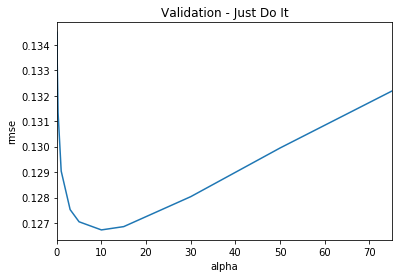

In [25]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [26]:
cv_ridge.min()

0.12672614964134807

In [27]:
# looks like the smallest error is with alpha = 10 
cv_ridge

0.05     0.134497
0.10     0.133461
0.30     0.131337
1.00     0.129039
3.00     0.127525
5.00     0.127046
10.00    0.126726
15.00    0.126856
30.00    0.128034
50.00    0.129947
75.00    0.132183
dtype: float64

In [28]:
# let train again model with alpha = 10
model_ridge = Ridge(alpha = 10).fit(X_train, y_train)
rmse_cv(model_ridge).mean()

0.12672614964134807

### predict and save

In [29]:
y_test_pred_log = model_ridge.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(y_test_pred_log)})
submission.to_csv("./output/sub-ridge-30_03_2017.csv", index=False)
submission.head()

,Id,SalePrice
1460,1461,118113.146107
1461,1462,152846.170517
1462,1463,181755.350754
1463,1464,197458.445245
1464,1465,198982.910886


## Linear regression with regularisation - LASSO (LB: 2.10687)

In [30]:
from sklearn.linear_model import LassoCV
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)


In [31]:
rmse_cv(model_lasso).mean()

0.12203213141209832

In [32]:
lasso_pred_log = model_lasso.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(lasso_pred_log)})
submission.to_csv("./output/sub-lasso-30_03_2017.csv", index=False)
submission.head()

,Id,SalePrice
1460,1461,119359.354694
1461,1462,152577.904688
1462,1463,180811.052798
1463,1464,197096.208156
1464,1465,201190.778838


## Xgboost (LB: 0.13411)

In [33]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

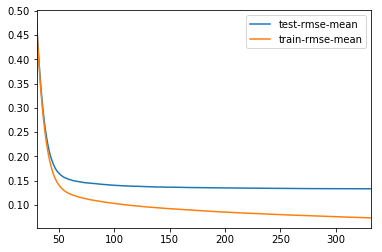

In [34]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [35]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [36]:
xgb_preds_log = model_xgb.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(xgb_preds_log)})
submission.to_csv("./output/sub-xgb-30_03_2017.csv", index=False)
submission.head()

,Id,SalePrice
1460,1461,120807.914062
1461,1462,156783.328125
1462,1463,184880.078125
1463,1464,190933.578125
1464,1465,187652.609375


## GradientBoosting (LB: 0.22011)

In [37]:
from sklearn.ensemble import GradientBoostingRegressor
params = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}

model_gbm = GradientBoostingRegressor(**params)
model_gbm.fit(X_train, y_train)

rmse_cv(model_gbm).mean()

0.20733171343705625

In [38]:
gbm_preds_log = model_gbm.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(gbm_preds_log)})
submission.to_csv("./output/sub-gbm-30_03_2017.csv", index=False)
submission.head()

,Id,SalePrice
1460,1461,142386.513020
1461,1462,155415.029302
1462,1463,177878.679814
1463,1464,165275.246472
1464,1465,186480.454000


## Save models

In [40]:
import pickle
pickle.dump(model_rf, open('./models/model-rf.pkl', 'wb'))
pickle.dump(model_xgb, open('./models/model-xgb.pkl', 'wb'))
pickle.dump(model_gbm, open('./models/model-gbm.pkl', 'wb'))
pickle.dump(model_lasso, open('./models/model-lasso.pkl', 'wb'))
pickle.dump(model_ridge, open('./models/model-ridge.pkl', 'wb'))